<a href="https://colab.research.google.com/github/Hijaab/PhishShield/blob/main/fypefficientnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/dataSet1'
COVER_PATH = os.path.join(PATH, 'Cover/')
JMIPOD_PATH = os.path.join(PATH, 'JMiPOD/')
TRAIN_PATHS = [COVER_PATH, JMIPOD_PATH]

TEST_PATH = os.path.join(PATH, 'Test/')

In [ ]:
!pip install colorama
!pip install opencv-python
!pip install tensorflow
!pip install albumentations
!pip install -q --upgrade efficientnet-pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00


In [ ]:
import os
import gc
import cv2
import sys
import time
from colorama import Fore

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from keras.utils import to_categorical
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.optim import Adam
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


from efficientnet_pytorch import EfficientNet
# from albumentations import Normalize, VerticalFlip, HorizontalFlip, Compose
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast,
    ShiftScaleRotate, Blur, GaussNoise, Normalize, Compose
)

train_transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    RandomBrightnessContrast(p=0.3),
    GaussNoise(p=0.2),
    Normalize(),
])
val_transform = Compose([
    Normalize()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
H = 512
W = 512
VF = 0.5
HF = 0.5
DELAY = 30

FOLDS = 4
FRAC = 1.0
EPOCHS = 5
BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
LR = [5e-5, 5e-4]
DELAY = 5

In [ ]:
import os

print("Training Folders:")
for p in TRAIN_PATHS:
    print(p, "→", len(os.listdir(p)), "images")

print(f"Test files: {os.listdir(TEST_PATH)[:5]}")


Training Folders:
/content/drive/MyDrive/dataSet1/Cover/ → 4999 images
/content/drive/MyDrive/dataSet1/JMiPOD/ → 4999 images
Test files: ['0224.jpg', '0186.jpg', '0263.jpg', '0213.jpg', '0252.jpg']


In [ ]:
from torch.utils.data import Dataset
from albumentations import Normalize, VerticalFlip, HorizontalFlip, Compose
import cv2
import numpy as np
from torch import FloatTensor

# This goes outside the class
def get_img(path, aug):
    img = cv2.imread(path, cv2.IMREAD_COLOR)  # Always read as 3-channel BGR
    if img is None:
        print(f"❌ Failed to load: {path}")
        return np.zeros((3, H, W), dtype=np.float32)

    img = cv2.resize(img, (W, H))  # Resize to (width, height)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = aug(image=img)['image']  # Apply albumentations
    img = np.transpose(img, (2, 0, 1))  # Convert from HWC → CHW
    return img.astype(np.float32)

# Your dataset class
class ALASKADataset(Dataset):
    def __init__(self, image_id, is_test, is_val):
        self.is_test = is_test
        self.image_id = image_id
        no_aug = is_test or is_val

        if no_aug:
            self.transform = Normalize(p=1)
        else:
            self.transform = Compose([
                VerticalFlip(p=VF),
                HorizontalFlip(p=HF),
                Normalize(p=1)
            ], p=1)

    def __len__(self):
        multiplier = 1 if self.is_test else 4
        return multiplier * len(self.image_id)

    def __getitem__(self, idx):
        index = idx % len(self.image_id)

        if self.is_test:
            path = TEST_PATH + self.image_id[index]
            img = get_img(path, self.transform)
            return FloatTensor(img)

        else:
            target = [int(idx / len(self.image_id) > 1)]
            path = TRAIN_PATHS[target[0]] + self.image_id[index]
            img = get_img(path, self.transform)
            return FloatTensor(img), FloatTensor(target)


In [ ]:
def GlobalAvgPooling(x):
    return x.mean(dim=2).mean(dim=2)  # safer for [B, C, H, W] format

class ENSModel(nn.Module):
    def __init__(self):
        super(ENSModel, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.avgpool = GlobalAvgPooling
        self.efn = EfficientNet.from_pretrained('efficientnet-b0')
        self.dense_output = nn.Linear(1280, 1)  # adjust for b0


    def forward(self, x):
        # Assuming input is already [B, 3, H, W]
        feat = self.efn.extract_features(x)
        pooled = self.avgpool(feat)
        output = self.dense_output(pooled)
        return self.sigmoid(output)


In [ ]:

model = ENSModel()

del model
gc.collect()

Loaded pretrained weights for efficientnet-b0


13503

In [ ]:
kfolds = KFold(n_splits=FOLDS)
image_id = os.listdir(COVER_PATH)
split_indices = kfolds.split(image_id)

val_ids, train_ids = [], []
for index in split_indices:
    val_ids.append(np.array(image_id)[index[1]])
    train_ids.append(np.array(image_id)[index[0]])

In [ ]:
def bce(inp, targ):
    return nn.BCELoss()(inp, targ)

def detach(tensors):
    return [tensor.detach().cpu() for tensor in tensors]

def acc(inp, targ):
    targ_idx = targ.squeeze()
    inp_idx = torch.round(inp).squeeze()
    return (inp_idx == targ_idx).float().sum(axis=0)/len(inp_idx)

In [ ]:
def print_metric(data, fold, start, end, metric, typ):
    n, value = "Steganalysis", np.round(data.item(), 3)
    g, c, y, r = Fore.GREEN, Fore.CYAN, Fore.YELLOW, Fore.RESET

    tick = g + '\u2714' + r
    t = typ, n, metric, c, value, r
    time = np.round(end - start, 1)
    time = "Time: {}{}{} s".format(y, time, r)
    string = "FOLD {} ".format(fold + 1) + tick + "  "
    print(string + "{} {} {}: {}{}{}".format(*t) + "  " + time)

In [ ]:
MODEL_PATH = "/content/efficientnet_model"


In [ ]:
def run(fold):
    val = val_ids[fold]
    train = train_ids[fold]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    val_set = ALASKADataset(val, False, True)
    train_set = ALASKADataset(train, False, False)
    val_loader = DataLoader(val_set, batch_size=VAL_BATCH_SIZE, shuffle=True)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    network = ENSModel().to(device)
    optimizer = Adam([
        {'params': network.efn.parameters(), 'lr': LR[0]},
        {'params': network.dense_output.parameters(), 'lr': LR[1]}
    ])

    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, eps=1e-6)

    start = time.time()
    for epoch in range(EPOCHS):
        network.train()
        for batch_idx, (train_img, train_targs) in enumerate(train_loader):
            train_img = train_img.to(device)
            train_targs = train_targs.to(device)

            train_preds = network(train_img)
            train_loss = bce(train_preds, train_targs)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if batch_idx + 1 >= FRAC * len(train_loader):
                break

        # Validation
        network.eval()
        val_preds, val_targs = [], []
        with torch.no_grad():
            for batch_idx, (img, targ) in enumerate(val_loader):
                img = img.to(device)
                targ = targ.to(device)
                pred = network(img)
                val_preds.append(pred)
                val_targs.append(targ)

                if batch_idx + 1 >= FRAC * len(val_loader):
                    break

        val_preds = torch.cat(val_preds, axis=0)
        val_targs = torch.cat(val_targs, axis=0)

        val_acc = acc(val_preds, val_targs)
        val_loss = bce(val_preds, val_targs)

        scheduler.step(val_loss)

        val_acc, val_loss = detach([val_acc, val_loss])
        val_preds, val_targs = detach([val_preds, val_targs])

        print(f"Epoch {epoch+1}/{EPOCHS}, Train loss: {train_loss.item():.4f}, Val Acc: {val_acc:.4f}")

    end = time.time()
    time.sleep(DELAY * fold)

    path = MODEL_PATH + f"_{fold + 1}.pt"
    torch.save(network.state_dict(), path)

    print_metric(val_acc, fold, start, end, "Accuracy", "Val")
    del network
    gc.collect()

    return val_acc.item()


In [ ]:
fold_accuracies = []

for i in range(FOLDS):
    acc_result = run(i)
    fold_accuracies.append(acc_result)

# Print per-fold and average
print("Fold Accuracies:", ["{:.2f}%".format(a * 100) for a in fold_accuracies])
print("Average Accuracy: {:.2f}%".format(sum(fold_accuracies) / len(fold_accuracies) * 100))



Loaded pretrained weights for efficientnet-b0
Epoch 1/5, Train loss: 0.6059, Val Acc: 0.7486
Epoch 2/5, Train loss: 0.8504, Val Acc: 0.7498
Epoch 3/5, Train loss: 0.5757, Val Acc: 0.7498
Epoch 4/5, Train loss: 0.6254, Val Acc: 0.7498
Epoch 5/5, Train loss: 0.3044, Val Acc: 0.7500
FOLD 1 ✔  Val Steganalysis Accuracy: 0.75  Time: 6373.8 s
Loaded pretrained weights for efficientnet-b0
Epoch 1/5, Train loss: 0.2896, Val Acc: 0.7494
Epoch 2/5, Train loss: 0.8556, Val Acc: 0.7498
Epoch 3/5, Train loss: 1.1360, Val Acc: 0.7498
Epoch 4/5, Train loss: 1.1730, Val Acc: 0.7498
Epoch 5/5, Train loss: 0.7307, Val Acc: 0.7504
FOLD 2 ✔  Val Steganalysis Accuracy: 0.75  Time: 1238.4 s
Loaded pretrained weights for efficientnet-b0
Epoch 1/5, Train loss: 0.6193, Val Acc: 0.7494
Epoch 2/5, Train loss: 0.5874, Val Acc: 0.7498
Epoch 3/5, Train loss: 0.3178, Val Acc: 0.7498
Epoch 4/5, Train loss: 0.2607, Val Acc: 0.7498
Epoch 5/5, Train loss: 0.4787, Val Acc: 0.7504
FOLD 3 ✔  Val Steganalysis Accuracy: 0.75

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
✅ Feature shape: (9998, 1280)
✅ Files saved:
 - X_pca_reduced.npy
 - y_labels.npy
 - pca_features_with_labels.csv


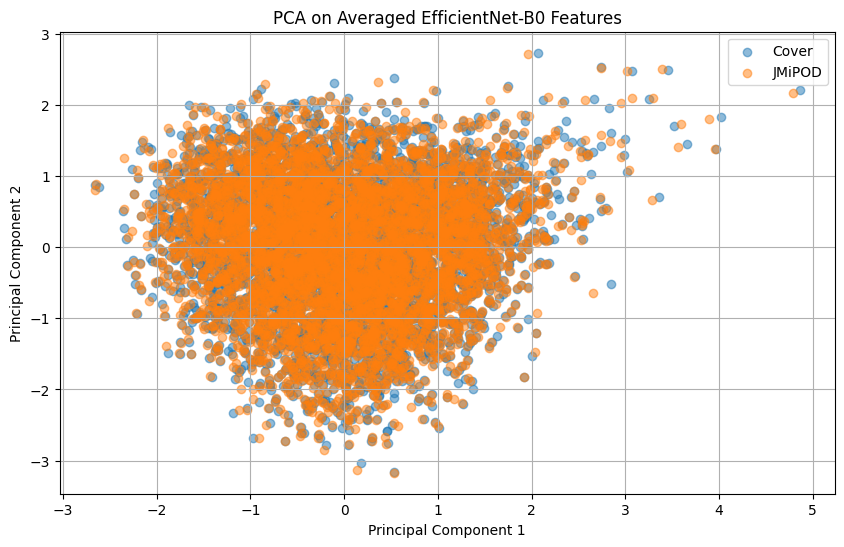

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from efficientnet_pytorch import EfficientNet
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== CONFIG ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/content/drive/MyDrive/dataSet1"  # Update if needed
BATCH_SIZE = 32
IMG_SIZE = 224
MODEL_PATHS = [
    "/content/efficientnet_model_1.pt",
    "/content/efficientnet_model_2.pt",
    "/content/efficientnet_model_3.pt",
    "/content/efficientnet_model_4.pt",
]

# ========== GLOBAL AVERAGE POOLING FUNCTION ==========
def GlobalAvgPooling(x):
    return x.mean(dim=2).mean(dim=2)  # safer for [B, C, H, W]

# ========== ORIGINAL TRAINED MODEL STRUCTURE ==========
class ENSModel(nn.Module):
    def __init__(self):
        super(ENSModel, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.avgpool = GlobalAvgPooling
        self.efn = EfficientNet.from_pretrained('efficientnet-b0')
        self.dense_output = nn.Linear(1280, 1)

    def forward(self, x):
        feat = self.efn.extract_features(x)
        pooled = self.avgpool(feat)
        output = self.dense_output(pooled)
        return self.sigmoid(output)

# ========== FEATURE EXTRACTOR ==========
class FeatureExtractor(nn.Module):
    def __init__(self, efficientnet):
        super().__init__()
        self.features = efficientnet.extract_features
        self.pool = GlobalAvgPooling

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return x

# ========== DATASET CLASS ==========
class StegoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = []
        self.labels = []
        self.transform = transform

        for label, folder in enumerate(["Cover", "JMiPOD"]):
            full_path = os.path.join(root_dir, folder)
            for fname in os.listdir(full_path):
                self.img_paths.append(os.path.join(full_path, fname))
                self.labels.append(label)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ========== TRANSFORM ==========
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========== DATA LOADER ==========
dataset = StegoDataset(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========== LOAD MODELS ==========
def load_model(path):
    model = ENSModel()
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.to(DEVICE)  # ✅ Move full model to GPU
    model.eval()
    return FeatureExtractor(model.efn).to(DEVICE)  # ✅ Also move extractor to GPU

models = [load_model(path) for path in MODEL_PATHS]

# ========== FEATURE EXTRACTION ==========
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(DEVICE)

        # Get features from all 4 models and average
        features_list = [model(images).cpu().numpy() for model in models]
        avg_features = np.mean(features_list, axis=0)

        all_features.append(avg_features)
        all_labels.append(labels.numpy())

X = np.concatenate(all_features)
y = np.concatenate(all_labels)

print(f"✅ Feature shape: {X.shape}")  # e.g., (10000, 1280)

# ========== PCA ==========
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# ========== SAVE ==========
np.save("X_pca_reduced.npy", X_reduced)
np.save("y_labels.npy", y)

df = pd.DataFrame(X_reduced, columns=["PC1", "PC2"])
df["Label"] = y
df.to_csv("pca_features_with_labels.csv", index=False)

print("✅ Files saved:")
print(" - X_pca_reduced.npy")
print(" - y_labels.npy")
print(" - pca_features_with_labels.csv")

# ========== PLOT ==========
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label='Cover', alpha=0.5)
plt.scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label='JMiPOD', alpha=0.5)
plt.title("PCA on Averaged EfficientNet-B0 Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


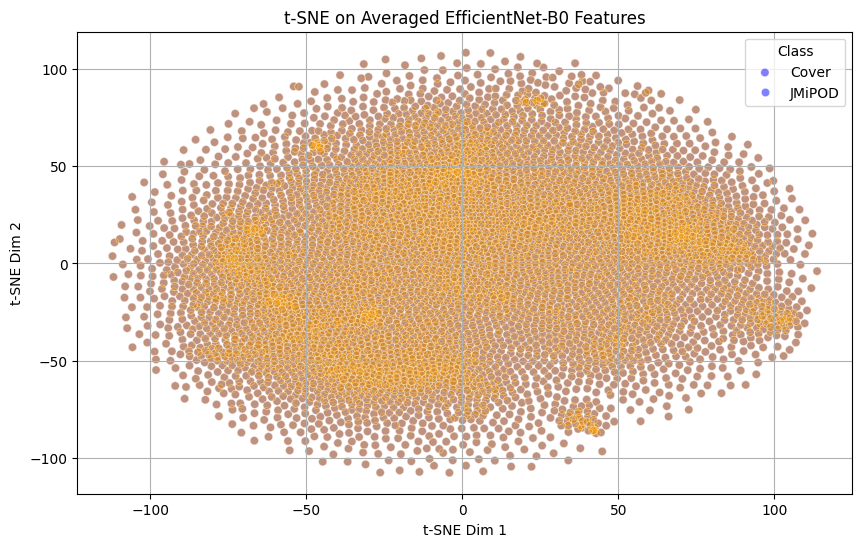

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# ========== t-SNE ==========
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

# ========== SAVE ==========
np.save("X_tsne_reduced.npy", X_tsne)
df_tsne = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
df_tsne["Label"] = y
df_tsne.to_csv("tsne_features_with_labels.csv", index=False)

# ========== PLOT ==========
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x="Dim1", y="Dim2", hue="Label", palette={0: "blue", 1: "orange"}, alpha=0.5)
plt.title("t-SNE on Averaged EfficientNet-B0 Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.legend(title="Class", labels=["Cover", "JMiPOD"])
plt.show()
